In [1]:
import numpy as np
import progressbar 
import random 
import os
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

import keras
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, model_from_json

import matplotlib.pyplot as plt
%matplotlib inline

from helpers import HDF5DatasetWriter
from helpers import Utils

Using TensorFlow backend.


In [2]:
root = 'datasets/UCF-101-frames-resize/'
include = ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 
           'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball']

In [3]:
full_categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in full_categories if c in [os.path.join(root, e) for e in include]]

In [4]:
categories

['datasets/UCF-101-frames-resize/ApplyEyeMakeup',
 'datasets/UCF-101-frames-resize/ApplyLipstick',
 'datasets/UCF-101-frames-resize/Archery',
 'datasets/UCF-101-frames-resize/BabyCrawling',
 'datasets/UCF-101-frames-resize/BalanceBeam',
 'datasets/UCF-101-frames-resize/BandMarching',
 'datasets/UCF-101-frames-resize/BaseballPitch',
 'datasets/UCF-101-frames-resize/Basketball']

In [5]:
def get_image(img_path):
    img = cv2.imread(img_path)
    return img

In [6]:
img = get_image("datasets/UCF-101-frames-resize/ApplyEyeMakeup/v_ApplyEyeMakeup_g06_c04_3.jpg")

In [7]:
img.shape

(60, 80, 3)

In [8]:
import pickle
rgbmean = pickle.load(open('../input/datasets/UCF-101-hdf5/rgbmean.pkl', 'rb'))

In [9]:
json_file = open('../output/saved/ucf101_model_xception_99.43.json', 'r')
transfer_model_json = json_file.read()
json_file.close()
transfer_model = model_from_json(transfer_model_json)
transfer_model.load_weights("../output/saved/ucf101_weight_xception_99.43.hdf5")

In [10]:
model = Model(inputs=transfer_model.input, 
              outputs=transfer_model.get_layer('batch_normalization_36').output)

In [11]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    
    current_squence_name = []
    next_squence_name = images[0].split('/')[2].split('_')[1:3]
    img_sequence = []
    
    for img_path in images:
        squence_name = img_path.split('/')[2].split('_')[1:3]
        current_squence_name = squence_name
        
        if current_squence_name == next_squence_name:
            img = get_image(img_path)
            (B, G, R) = cv2.split(img.astype("float32"))
            R -= rgbmean["R"]
            G -= rgbmean["G"]
            B -= rgbmean["B"]
            img = cv2.merge([B, G, R])
            img = img_to_array(img)
            img = imagenet_utils.preprocess_input(img)
            img_sequence.append(img)
        else:
            next_squence_name = current_squence_name
            data.append({'imgs':np.array(img_sequence), 'label':c})
            img_sequence = []
    data.append({'imgs':np.array(img_sequence), 'label':c})

In [12]:
data = np.array(data)
data[37]['imgs'].shape

(39, 60, 80, 3)

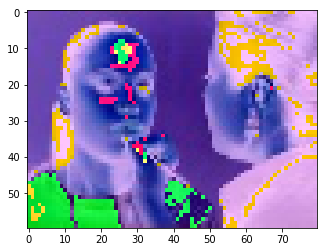

In [13]:
plt.imshow(data[35]['imgs'][0])
plt.show()

In [14]:
import pickle
pickle.dump(data, open('datasets/UCF-101-hdf5/full_sequence_rgbmean.pkl', 'wb'))
#full_sequence = pickle.load(open('datasets/UCF-101-hdf5/full_sequence', 'rb'))